### Hierarchical Clustering - Agglomerative

In [1]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial import distance_matrix 
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy
import warnings

matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cars_clus.csv')

In [3]:
columns = [
    'sales', 
    'resale', 
    'type', 
    'price', 
    'engine_s',
    'horsepow', 
    'wheelbas', 
    'width', 
    'length', 
    'curb_wgt', 
    'fuel_cap',
    'mpg', 
    'lnsales'
]
df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')

In [4]:
df = df.dropna()
df = df.reset_index(drop=True)

In [5]:
columns = [
    'engine_s',  
    'horsepow', 
    'wheelbas',
    'width',
    'length',
    'curb_wgt', 
    'fuel_cap',
    'mpg'
]
dataset = df[columns]

In [6]:
X = dataset.values
mms = MinMaxScaler()
features = mms.fit_transform(X)

In [7]:
leng = features.shape[0]
D = scipy.zeros([leng, leng])

for i in range(leng):
    for j in range(leng):
        D[i,j] = euclidean(features[i], features[j])

In [8]:
Z = linkage(D, 'complete')

In [9]:
k = 3
clusters = fcluster(Z, k, criterion='distance')

In [10]:
def llf(id):
    return '[%s %s %s]' % (df['manufact'][id], df['model'][id], int(float(df['type'][id])))

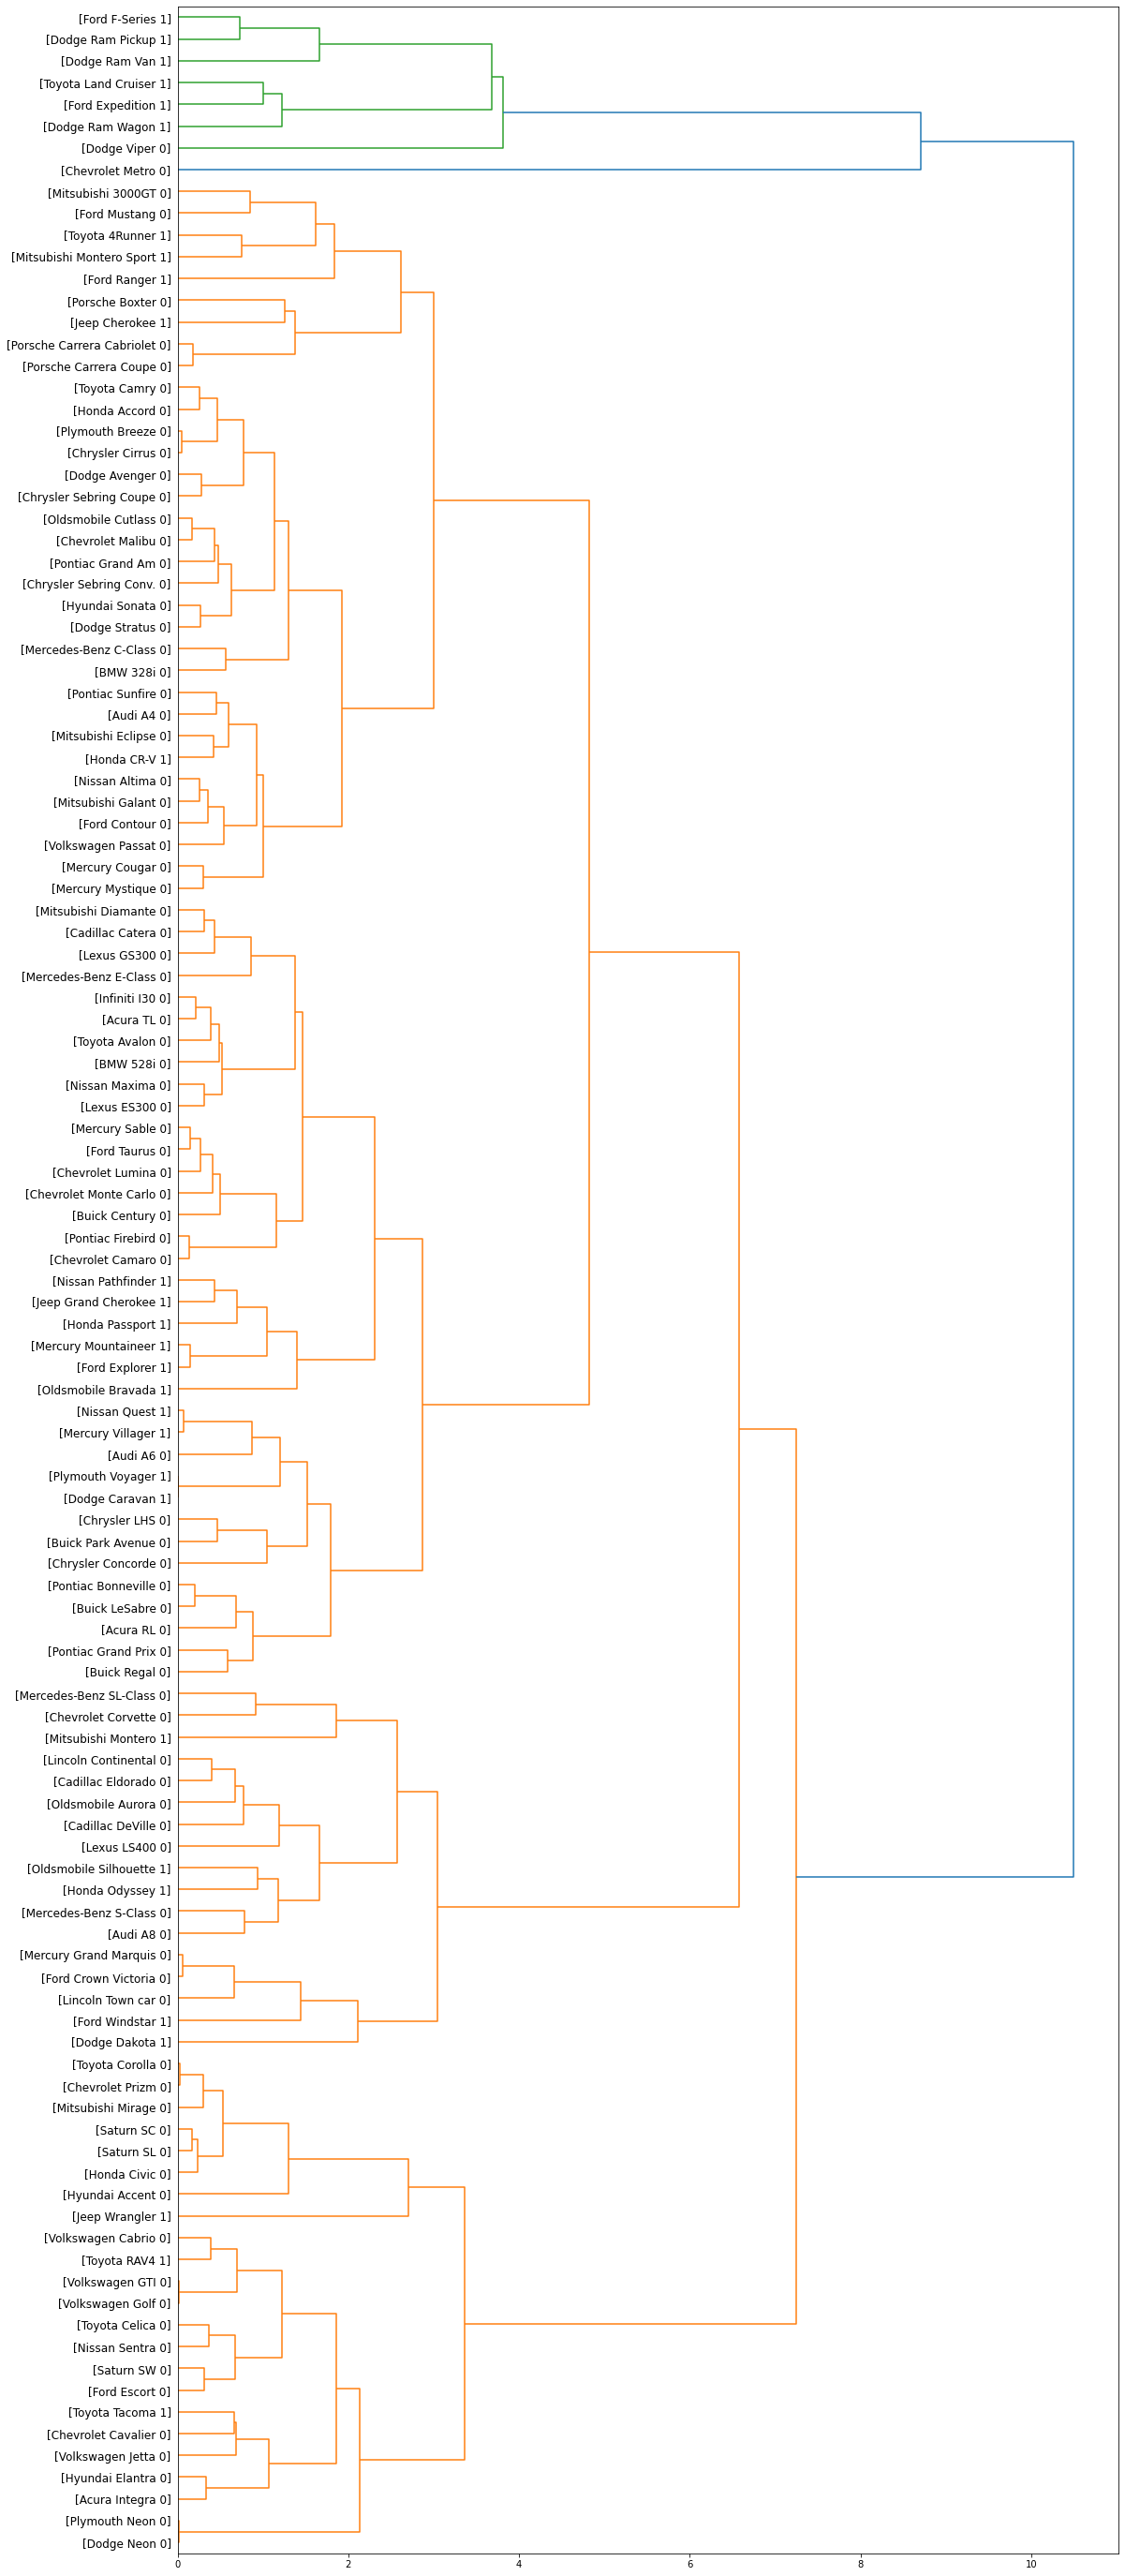

In [11]:
fig = pylab.figure(figsize=(18,50))
dendro = dendrogram(Z, leaf_label_func=llf, leaf_rotation=0, leaf_font_size=12, orientation='right')

### Clustering using scikit-learn

Now, we can use the 'AgglomerativeClustering' function from scikit-learn library to cluster the dataset. The AgglomerativeClustering performs a hierarchical clustering using a bottom up approach. The linkage criteria determines the metric used for the merge strategy:

- Ward minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
- Maximum or complete linkage minimizes the maximum distance between observations of pairs of clusters.
- Average linkage minimizes the average of the distances between all observations of pairs of clusters.

In [12]:
dist_matrix = distance_matrix(features, features)

In [13]:
agglom = AgglomerativeClustering(n_clusters=6, linkage='complete')

In [14]:
agglom.fit(features)

AgglomerativeClustering(linkage='complete', n_clusters=6)

In [15]:
df['cluster'] = agglom.labels_

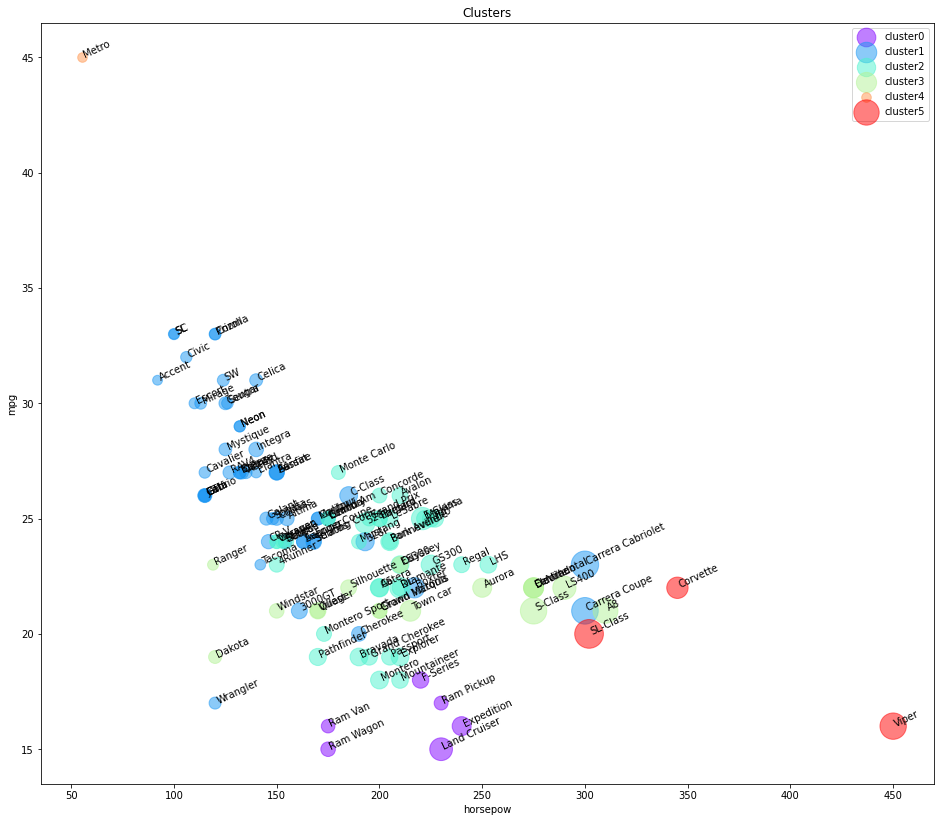

In [16]:
n_clusters = max(agglom.labels_) + 1
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_labels = list(range(0, n_clusters))

plt.figure(figsize=(16, 14))

for color, label in zip(colors, cluster_labels):
    subset = df[df.cluster == label]
    for i in subset.index:
            plt.text(
                subset.horsepow[i],
                subset.mpg[i],
                str(subset['model'][i]),
                rotation=25
            ) 
            
    plt.scatter(
        subset.horsepow,
        subset.mpg,
        s= subset.price * 10,
        c=color,
        label='cluster' + str(label),
        alpha=0.5
    )
    
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg');

In [17]:
cols = [
    'horsepow',
    'engine_s',
    'mpg',
    'price'
]
agg_cars = df.groupby(['cluster', 'type'])[cols].mean()
agg_cars

horsepow  engine_s        mpg      price
cluster type                                            
0       1.0   211.666667  4.483333  16.166667  29.024667
1       0.0   146.531915  2.246809  27.021277  20.306128
        1.0   145.000000  2.580000  22.200000  17.009200
2       0.0   203.111111  3.303704  24.214815  27.750593
        1.0   182.090909  3.345455  20.181818  26.265364
3       0.0   256.500000  4.410000  21.500000  42.870400
        1.0   160.571429  3.071429  21.428571  21.527714
4       0.0    55.000000  1.000000  45.000000   9.235000
5       0.0   365.666667  6.233333  19.333333  66.010000

It is obvious that we have 3 main clusters with the majority of vehicles in those.

**Cars**:

-   Cluster 1: with almost high mpg, and low in horsepower.
-   Cluster 2: with good mpg and horsepower, but higher price than average.
-   Cluster 3: with low mpg, high horsepower, highest price.

**Trucks**:

-   Cluster 1: with almost highest mpg among trucks, and lowest in horsepower and price.
-   Cluster 2: with almost low mpg and medium horsepower, but higher price than average.
-   Cluster 3: with good mpg and horsepower, low price.

Please notice that we did not use **type** , and **price** of cars in the clustering process, but Hierarchical clustering could forge the clusters and discriminate them with quite high accuracy.

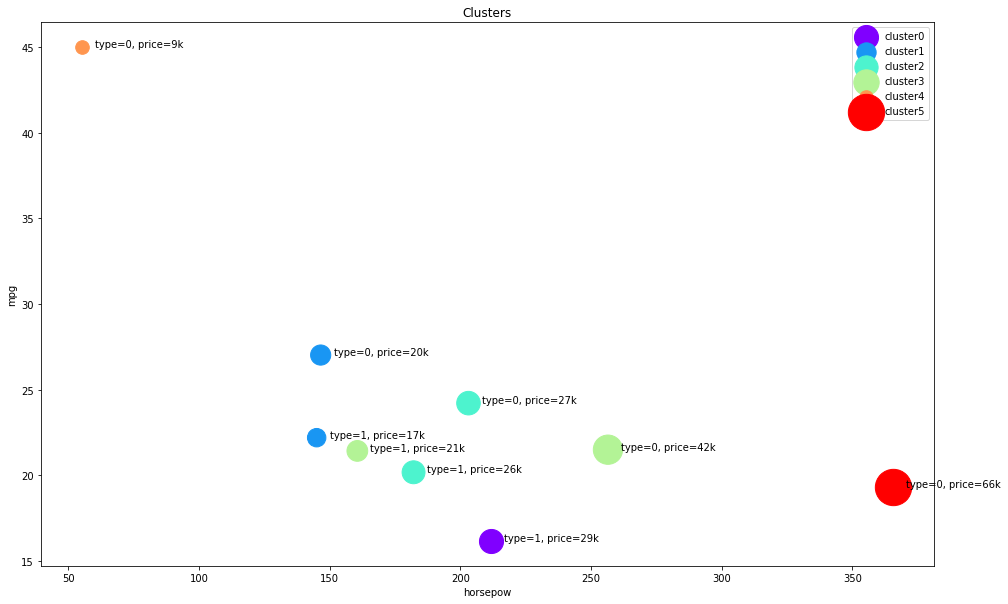

In [18]:
plt.figure(figsize=(16, 10))

for color, label in zip(colors, cluster_labels):
    subset = agg_cars.loc[(label,),]
    
    for i in subset.index:
        plt.text(
            subset.loc[i][0] + 5,
            subset.loc[i][2],
            'type=' + str(int(i)) + ', price=' + str(int(subset.loc[i][3])) + 'k'
        )
    
    plt.scatter(subset.horsepow, subset.mpg, s=subset.price*20, c=color, label='cluster'+str(label))
    
plt.legend()
plt.title('Clusters')
plt.xlabel('horsepow')
plt.ylabel('mpg');